In [1]:
from gensim import corpora
from gensim import models
import numpy as np
from scipy.sparse import csr_array
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
from motifs.features import bow_to_matrix, bow_to_dataframe
import json
import pandas as pd

# Load data

In [8]:
data_path = "../data/canon"
docs = os.listdir(f"{data_path}/tokens_canon")

# Metadata
metadata = pd.read_csv(f"{data_path}/metadata.csv", index_col=0)
docs = [d for d in docs if d in metadata["doc_id"].tolist()]


SEGMENTS = [
    [1800, 1826],
    [1827, 1850],
    [1851, 1869],
    [1870, 1899],
    [1900, 1945],
    [1946, 2024],
]
SEGMENTS = pd.DataFrame(SEGMENTS, columns=["start", "end"])
s_seg = 50

def get_seg_from_date(date, segments):
    return segments[(segments["start"] <= date) & (date <= segments["end"])].index[0]
    
metadata["segment"] = metadata["date_publication"].apply(lambda x: get_seg_from_date(x, SEGMENTS))
metadata.doc_id = metadata.doc_id.str.replace(".csv", "")
metadata

,doc_id,titre,author,sexe,birth_date,death_date,date_publication,etiquette,segment
X,,,,,,,,,
7,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,"La Vierge de l'Indostan, ou les Portugais au M...","Barthélemy-Hadot, Marie-Adélaïde",female,1763,1821,1816,non-canon,0
9,1816_Bournon-Malarme-Charlotte-de_Lancelot-Mon...,"Lancelot Montagu, ou le Résultat des bonnes fo...","Bournon-Malarme, Charlotte de",female,1753,1830,1816,non-canon,0
12,1817_Barthelemy-Hadot-Marie-Adelaide_Les-venit...,"Les Vénitiens, ou le Capitaine français (Tome 1)","Barthélemy-Hadot, Marie-Adélaïde",female,1763,1821,1817,non-canon,0
13,1817_Barthelemy-Hadot-Marie-Adelaide_Les-Venit...,"Les Vénitiens, ou le Capitaine français (Tome 2)","Barthélemy-Hadot, Marie-Adélaïde",female,1763,1821,1817,non-canon,0
18,1821_Arlincourt-Charles-Victor_Le-Solitaire,Le Solitaire,"Arlincourt, Charles-Victor Prévost d'",male,1788,1856,1821,non-canon,0
...,...,...,...,...,...,...,...,...,...
2231,1955_Veuzit-Max-du_A-l'ombre-d'un-coeur,A l'ombre d'un coeur,"Vavasseur, Alphonsine Zéphirine dite du Veuzit...",female,1876,1952,1955,non-canon,5
2234,1956_Delly_La-biche-au-bois,La biche au bois,"Petitjean de la Rosière, Jeanne-Marie",female,1875,1947,1956,non-canon,5
2411,1971_Veuzit-Max-du_Rien-qu'une-nuit,Rien qu'une nuit,"Vavasseur, Alphonsine Zéphirine dite du Veuzit...",female,1876,1952,1951,non-canon,5


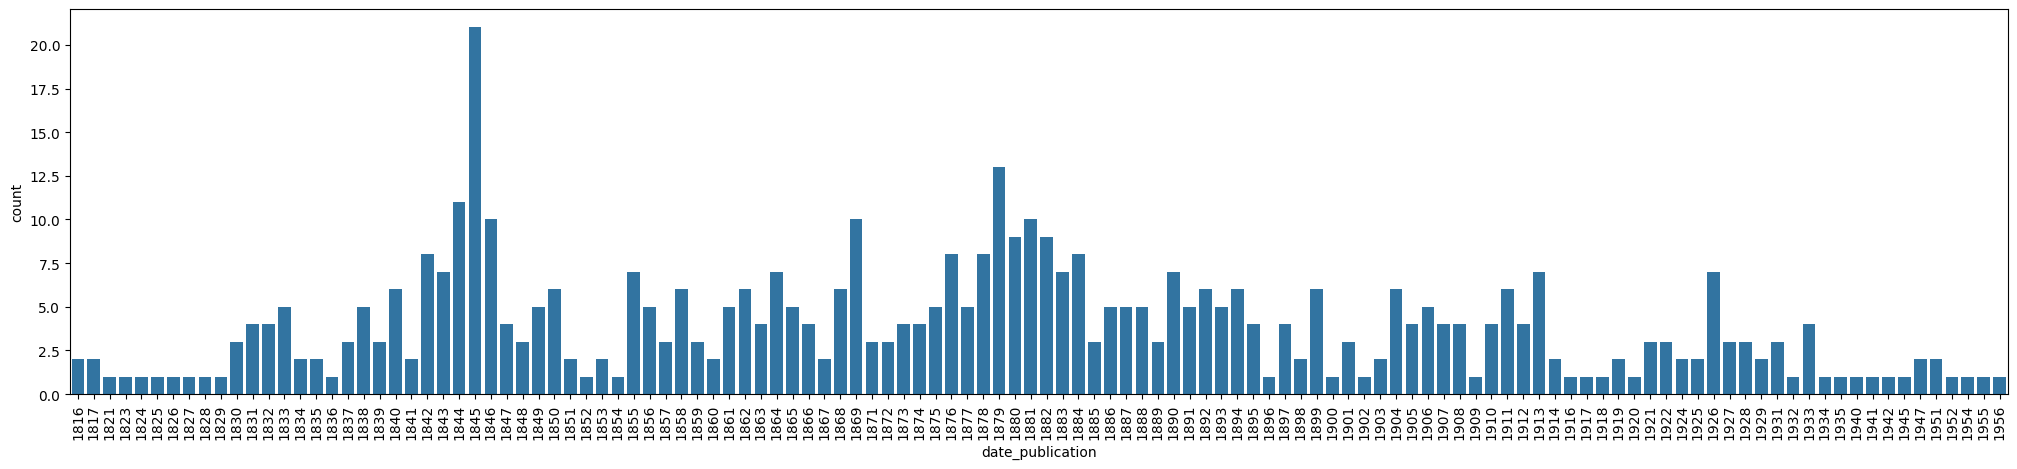

In [3]:
plt.figure(figsize=(25,5))
sns.barplot(metadata["date_publication"].value_counts())
plt.xticks(rotation=90)
plt.show()

# Get ngrams

In [9]:
ngrams = pd.read_csv("/Users/brunospilak/Documents/Sorbonne/PyMotifs/data_backup/ngrams_canon.csv", index_col=0)
docs = list(set(ngrams.doc.unique()))
tokeep = ngrams.groupby("doc")["token"].value_counts()
tokeep = tokeep[tokeep > 1]
ngrams = ngrams.set_index(["doc", "token"]).loc[tokeep.index].reset_index()
texts = [
    ngrams[ngrams["doc"] == d]["token"].tolist() for d in docs
]
segments = metadata.set_index("doc_id").loc[docs, "segment"]

# Compute TFIDF

In [10]:
# Create dictionary with gensim
dictionary = corpora.Dictionary(texts)
# Get Bag of words representation
bow_corpus = [dictionary.doc2bow(text) for text in texts]
# Fit the tfidf
model = models.TfidfModel(bow_corpus, normalize=False)
# Create a sparse matrix
mat_tfidf = bow_to_matrix([model[d] for d in bow_corpus], shape=(len(bow_corpus), len(dictionary.token2id)))

In [11]:
# Keep approximately the n less sparse features
n = 10000
freq_nonzeros = np.sum(mat_tfidf.toarray() != 0, axis=0) / mat_tfidf.shape[0]
mask = freq_nonzeros >= np.quantile(freq_nonzeros, 1 - n/mat_tfidf.shape[-1]) # 0.05
features = mat_tfidf[:,mask]

# Save names of columns and indices
index=docs
columns = list({id_: dictionary[id_] for i, id_ in enumerate(dictionary.token2id.values()) if mask[i]}.values())

features.shape

(217, 10075)

# Clustering

We have roughly 10000 features and 217 documents. The features are TFIDF features, thus definitely not gaussian. We can expect KMeans to perform very badly on the raw table. On top, we can suspect non-linear relationship between the documents.

We propose to use a manifold learning techning, TSNE, to reduce the dimension of the feature spaces. TSNE helps use to visualize potential clusters in the dataset.

In [12]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn import metrics

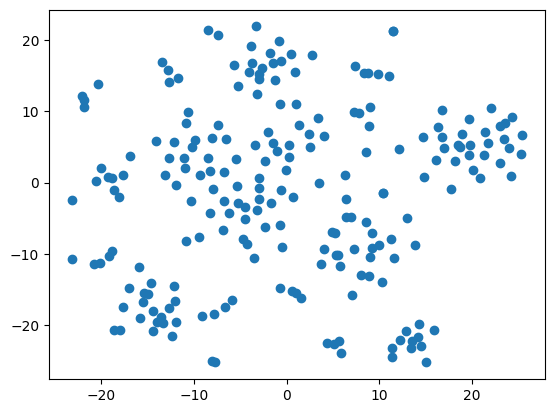

In [13]:
# First, we normalize each TFIDF vector
random_state=1
X = normalize(features, norm='l2', axis=1)
# X = features.copy()

embedding = TSNE(
        n_components=2, learning_rate=10, 
        init='random', early_exaggeration=50,
        perplexity=10, random_state=random_state
).fit_transform(X)
plt.scatter(x=embedding[:,0], y=embedding[:,1])
plt.show()

We can observe some clusters. We use DBSCAN method to find the clusters, since it does not require to specify the number of clusters.

Silhouette DBSCAN 0.49208096


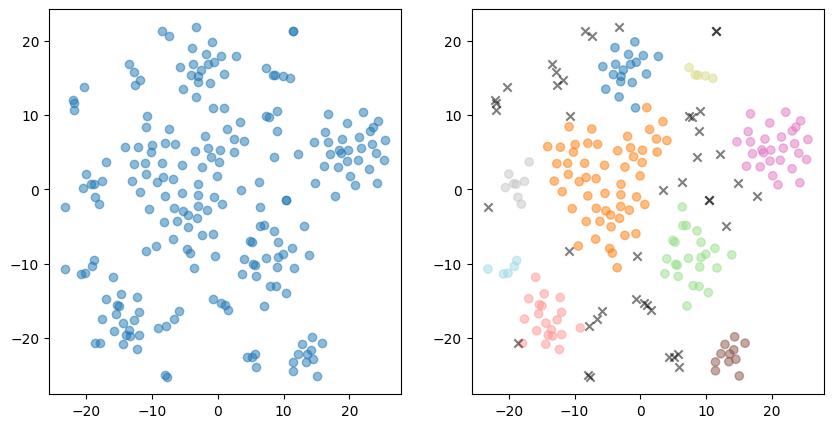

In [70]:
n_clusters = 8

clusterer = DBSCAN(eps=3, min_samples=5, metric="euclidean")
cluster_labels = clusterer.fit_predict(embedding)
clustered_points = np.array(range(len(embedding)))[cluster_labels != -1]
silhouette_avg = metrics.silhouette_score(embedding[clustered_points, :], cluster_labels[clustered_points], metric='euclidean')
print("Silhouette DBSCAN", silhouette_avg)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(x=embedding[:,0], y=embedding[:,1], alpha=0.5)
scatter = axs[1].scatter(
    x=embedding[cluster_labels != -1, 0], 
    y=embedding[cluster_labels != -1, 1], 
    c=dbscan.labels_[cluster_labels != -1], cmap="tab20", alpha=0.5
)
axs[1].scatter(
    x=embedding[cluster_labels == -1,0], 
    y=embedding[cluster_labels == -1,1], 
    marker="x",
    c="black",
    alpha=0.5,
)

plt.show()


We observe that DBSCAN found 9 clusters, the grey cross points being classified as noise.

In [386]:
from sklearn.metrics import silhouette_samples, silhouette_score


def plot_clusters(X, cluster_labels, ax=None, title=None):
    n_clusters = len(set(cluster_labels))
    noise = cluster_labels == -1
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    if ax is None:
        ax = plt
    if sum(noise) > 0:
        ax.scatter(
            X[~noise, 0], X[~noise, 1], lw=0, alpha=0.7,
            c=colors[~noise], edgecolor="k"
        )
        ax.scatter(
            X[noise, 0], X[noise, 1], marker="x", alpha=0.5, s=30,
            c="grey",
        )
    else:
        ax.scatter(
            X[:, 0], X[:, 1], lw=0, alpha=0.7,
            c=colors[~noise], edgecolor="k"
        )

    # Labeling the clusters
    centers = np.array(
        [np.mean(X[cluster_labels == i, :], axis=0) for i in
         set(cluster_labels) if i != -1])
    # Draw white circles at cluster centers
    ax.scatter(
        centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        label = list(set(cluster_labels))[i]
        if label != -1:
            ax.scatter(
                c[0], c[1], marker="$%d$" % label, alpha=1, s=50,
                edgecolor="k",
            )
    if title is not None:
        ax.set_title(title)
    
def silhouette_plot(X, cluster_labels, metric: str = 'euclidean'):
    """
    cf: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    :param X:
    :param cluster_labels:
    :return:
    """
    if -1 in cluster_labels:
        n_clusters = len(set(cluster_labels)) - 1
    else:
        n_clusters = len(set(cluster_labels))

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in set(cluster_labels):
        if i != -1:
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[
                cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
            # Label the silhouette plots with their cluster numbers at the
            # middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10

    ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    noise = cluster_labels == -1
    silhouette_avg = silhouette_score(
        X[~noise, :], cluster_labels[~noise], metric=metric
    )
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    # ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    plot_clusters(X, cluster_labels, ax=ax2, title="Clustered Data")
    plt.suptitle(
        "Silhouette analysis for DBSCAN clustering on sample data with "
        "n_clusters = %d" % n_clusters, fontsize=14, fontweight="bold",
    )
    plt.show()

    return sample_silhouette_values

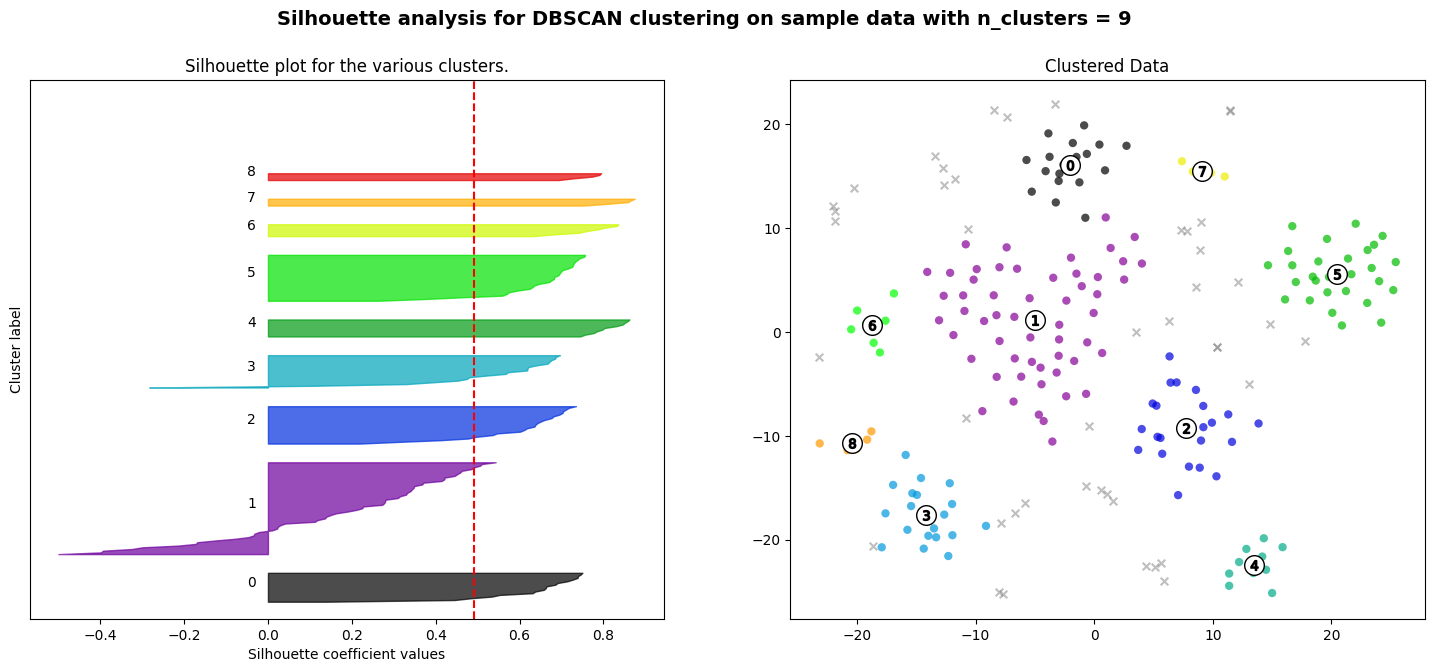

In [387]:
sample_silhouette_values = silhouette_plot(embedding, cluster_labels)

From the silhouette plot above, we observe that the a part from cluster 1 and 3, all clusters are very dense with respect to the Euclidean distance. A few negative silhouette scores in cluster 3 and in particular in cluster 1 indicate that some samples in these clusters maybe belong to another cluster or should be classified as noise. Indeed from the thickness of the silhouette, we deduce that cluster 1 is larger than the other cluster and contain maybe hetereogenous samples.
However the other clusters are quite dense and the average silhouette score of 0.49 shows that the clusters found by DBSCAN are well defined.
Let us confirm this by looking into the constitutions of the clusters.

In [82]:
clusters = {str(c): [] for c in cluster_labels}
for i, d in enumerate(docs):
    clusters[str(cluster_labels[i])].append(d)
# Save the clusters
# json.dump(clusters, aopen("clusters.json", "w"))
clusters

{'0': ['1845_Balzac-Honore-de_Un-debut-dans-la-vieFC',
  '1845_Balzac-Honore-de_Sur-Catherine-de-MedicisFC',
  '1845_Balzac-Honore-de_La-Recherche-de-l-Absolu',
  '1855_Balzac-Honore-de_Les-Petits-BourgeoisFC',
  '1843_Balzac-Honore-de_Ursule-Mirouet',
  '1843_Balzac-Honore-de_Histoire-des-Treize',
  '1855_Balzac-Honore-de_Les-PaysansFC',
  '1844_Balzac-Honore-de_La-Maison-Nucingen',
  '1845_Balzac-Honore-de_Un-drame-au-bord-de-la-merFC',
  '1843_Balzac-Honore-de_Le-Pere-GoriotFC',
  '1842_Balzac-Honore-de_Madame-Firmiani',
  '1846_Balzac-Honore-de_Un-prince-de-la-Boheme',
  '1844_Chateaubriand-François-Rene-de_Vie-de-Rance',
  '1845_Balzac-Honore-de_Gambara',
  '1845_Balzac-Honore-de_Le-RequisitionnaireFC',
  '1844_Balzac-Honore-de_L-InterdictionFC',
  '1855_Stendhal_Chroniques-italiennes',
  '1844_Balzac-Honore-de_Sarrasine'],
 '1': ['1874_Fleuriot-Zenaide_En-conge',
  '1845_Sue-Eugene_La-coucaratcha-Tome-III',
  '1855_Sand-George_Kourroglou',
  '1863_Pontmartin-Armand-de_Les-bruleu

# Clusters interpretation based on the metadata

In [ ]:
data = metadata.set_index("doc_id").loc[docs]
data["cluster"] = cluster_labels

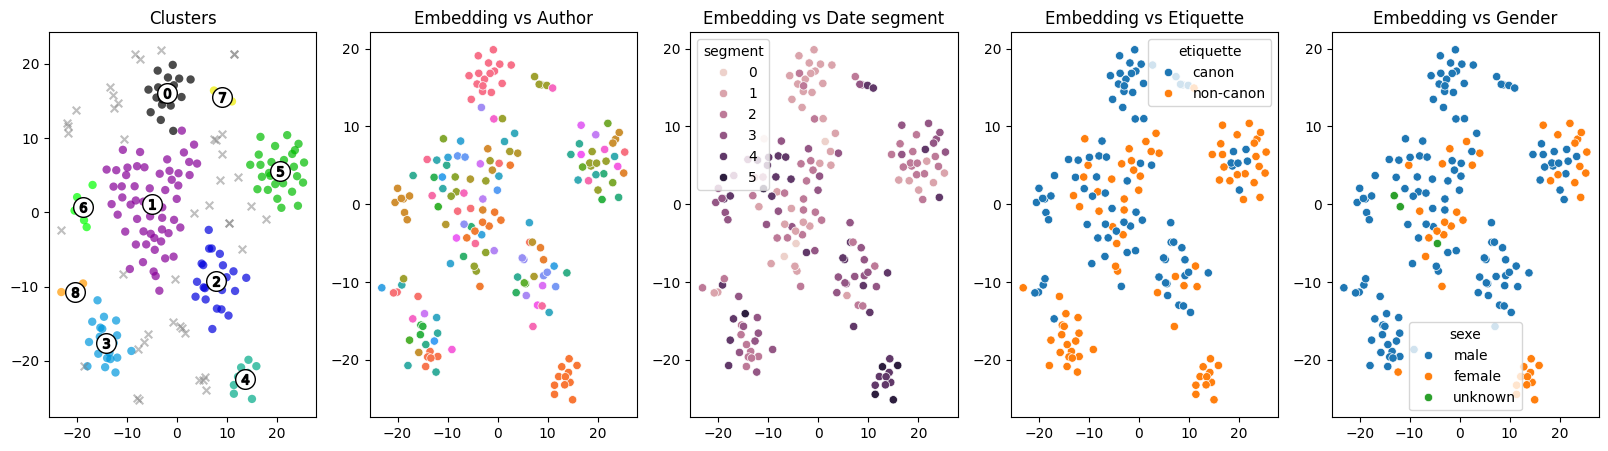

In [390]:
fig, axs = plt.subplots(1, 5, figsize=(20,5))
# Cluters
plot_clusters(embedding, cluster_labels, ax=axs[0], title="Clusters")

# Author
sns.scatterplot(x=embedding[cluster_labels!=-1,0], y=embedding[cluster_labels!=-1,1], 
                hue=data.loc[cluster_labels!=-1, "author"], legend=False, ax=axs[1])
axs[1].set_title("Embedding vs Author")
# Date
sns.scatterplot(x=embedding[cluster_labels!=-1,0], y=embedding[cluster_labels!=-1,1], 
                hue=data.loc[cluster_labels!=-1, "segment"], ax=axs[2])
axs[2].set_title("Embedding vs Date segment")

# Etiquette
sns.scatterplot(x=embedding[cluster_labels!=-1,0], y=embedding[cluster_labels!=-1,1], 
                hue=data.loc[cluster_labels!=-1, "etiquette"], ax=axs[3])
axs[3].set_title("Embedding vs Etiquette")

# Gender
sns.scatterplot(x=embedding[cluster_labels!=-1,0], y=embedding[cluster_labels!=-1,1], 
                hue=data.loc[cluster_labels!=-1, "sexe"], ax=axs[4])
axs[4].set_title("Embedding vs Gender")

plt.show()

From the plot above, it seems that the author variable can help interpret the cluster. Indeed, cluster 0, 4, and 6, seem to correspond to one author. The publication date, Etiquette, and Gender are dependent on the author.

On top, out of the 113 different authors reprensented in the corpus only 7 have texts groupped in different clusters. This is shown in the output below listing the clusters that have authors in common. For example, both cluster 1 and 5 contain texts written by A. Dumas (père) and Z. Fleuriot.

In [353]:
labels = list(set(cluster_labels[cluster_labels != -1]))
pairs = [(a, b) for idx, a in enumerate(labels) for b in labels[idx + 1:]]
authors_overlap = {}
for p in pairs:
    o = set(data.loc[cluster_labels==p[0], "author"]).intersection(
        set(data.loc[cluster_labels==p[1], "author"])
    )
    if len(o) > 0:
        authors_overlap[p] = o
authors_overlap

{(1, 5): {'Dumas (père), Alexandre', 'Fleuriot, Zénaïde'},
 (1, 8): {'Sue, Eugène'},
 (2, 6): {'Daudet, Alphonse'},
 (2, 8): {'Maricourt, René Du Mesnil'},
 (3, 5): {'Féval (père), Paul'},
 (7, 8): {'Verne, Jules'}}

## Contingency table

Another usefull statistics for categorical variables are contingency table. For example, we can ask ourselves: *What is the probability that a document in cluster $j$ is written by author $i$?*, *What is the probability that a document written by author $i$ is located in cluster $j$?*, *What is the probability that a document is written by a female in cluster $i$?* etc.


#### Author vs Cluster

In [463]:
crosstab_cluster_y = pd.crosstab(data["author"].astype("category"), data["cluster"].astype("category"))
crosstab_cluster_y

cluster,-1,0,1,2,3,4,5,6,7,8
author,,,,,,,,,,
"About, Edmond",0,0,0,0,0,0,2,0,0,0
"Aimard, Gustave",0,0,1,0,0,0,0,0,0,0
"Albalat, Antoine",0,0,0,1,0,0,0,0,0,0
"Apollinaire, Guillaume",1,0,0,1,0,0,0,0,0,0
"Arlincourt, Charles-Victor Prévost d'",0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
"Verne, Jules",0,0,0,0,0,0,0,0,4,1
"Vesco, Marie Delorme, Mme Léon",0,0,0,0,0,0,1,0,0,0
"Villiers de l'Isle-Adam, Auguste",1,0,1,0,0,0,0,0,0,0


**What is the probability that a document in cluster $i$ is written by Balzac?**
*89%* for cluster 0. Balzac is clearly overrepresented in cluster 0

In [464]:
# Sum by columns (clusters)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=0).values.reshape(1,-1)) * 100
df.loc[["Balzac, Honoré de"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8
author,,,,,,,,,,
"Balzac, Honoré de",11,89,0,0,0,0,0,0,0,0


**What is the probability that a document written by Balzac belongs to cluster $i$?**

Cluster 0 representes *76%* of Balzac texts.

In [465]:
# Sum by row (author)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=1).values.reshape(-1,1)) * 100
df.loc[["Balzac, Honoré de"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8
author,,,,,,,,,,
"Balzac, Honoré de",24,76,0,0,0,0,0,0,0,0


We can already say that cluster 0 mostly represent Balzac style as 76% of Balzac texts are in cluster 0 and 89% of the documents belonging to cluster 0 are from Balzac.

#### Gender vs Cluster

In [468]:
crosstab_cluster_y = pd.crosstab(data["sexe"].astype("category"), data["cluster"].astype("category"))
crosstab_cluster_y

cluster,-1,0,1,2,3,4,5,6,7,8
sexe,,,,,,,,,,
female,10,0,16,0,1,11,13,0,0,0
male,34,18,35,23,19,0,15,8,5,5
unknown,0,0,3,0,0,0,0,0,0,0


**What is the probability that a document in cluster $i$ is written by Female?**

100% for cluster 4 and 30% in cluster 1.

In [471]:
# Sum by columns (clusters)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=0).values.reshape(1,-1)) * 100
df.loc[["female"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8
sexe,,,,,,,,,,
female,23,0,30,0,5,100,46,0,0,0


**What is the probability that a document written by a female belongs to cluster $i$?**

Cluster 4 representes *22%* of texts written by female authors.

In [474]:
# Sum by row (author)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=1).values.reshape(-1,1)) * 100
df.loc[["female"]].style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8
sexe,,,,,,,,,,
female,20,0,31,0,2,22,25,0,0,0


# Publication date vs Cluster

In [487]:
crosstab_cluster_y = pd.crosstab(data["segment"].astype("category"), data["cluster"].astype("category"))
crosstab_cluster_y = crosstab_cluster_y.set_index(SEGMENTS["start"].astype(str) + " - " + SEGMENTS["end"].astype(str))

**What is the probability that a document in cluster $i$ was published at a given date?**

In cluster 5, 46% of the texts were published between 1851 and 1869. This period is overrepresented in this cluster. More than 92% of them were published between 1827 and 1900.

In [489]:
# Sum by columns (clusters)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=0).values.reshape(1,-1)) * 100
df.style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8
1800 - 1826,11,0,7,0,0,0,0,0,0,0
1827 - 1850,23,83,29,4,0,0,21,0,0,40
1851 - 1869,9,17,27,17,40,0,46,0,20,40
1870 - 1899,14,0,18,48,40,0,25,75,40,0
1900 - 1945,39,0,16,30,15,64,7,25,40,20
1946 - 2024,5,0,2,0,5,36,0,0,0,0


**What is the probability that a document published at a given date belongs to cluster $i$?**

More than a quarter of the texts that were published between 1851 and 1869 belongs to cluster 5. This is the second biggest score. It is fair to interpret cluster 5 as one describing well the literature of the Second Empire in France, but this is not the only characteristic of the group.

In [491]:
# Sum by columns (clusters)
df = (crosstab_cluster_y / crosstab_cluster_y.sum(axis=1).values.reshape(-1,1)) * 100
df.style.format(precision=0)

cluster,-1,0,1,2,3,4,5,6,7,8
1800 - 1826,56,0,44,0,0,0,0,0,0,0
1827 - 1850,20,30,32,2,0,0,12,0,0,4
1851 - 1869,8,6,30,8,16,0,26,0,2,4
1870 - 1899,12,0,20,22,16,0,14,12,4,0
1900 - 1945,34,0,18,14,6,14,4,4,4,2
1946 - 2024,25,0,12,0,12,50,0,0,0,0


## Cluster interpretation with respect to authors

In [391]:
def plot_one_cluster(label, figsize=(15,5)):
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    scatter = axs[0].scatter(
        embedding[:,0], embedding[:,1],  c=["red" if i else "grey" for i in cluster_labels==label],
        alpha=0.5
    )
    axs[0].set_title("Feature space")
    
    authors = metadata.set_index("doc_id").loc[docs][cluster_labels==label]["author"].astype("category")
    axs[1].scatter(embedding[cluster_labels!=label,0], embedding[cluster_labels!=label,1], c="grey", alpha=0.5)
    scatter = axs[1].scatter(
        embedding[cluster_labels==label][:,0], embedding[cluster_labels==label][:,1], 
        c=authors.cat.codes, alpha=1, cmap=None if len(authors.unique()) < 10 else "tab20"
    )
    # produce a legend with the unique colors from the scatter
    legend = axs[1].legend(
        scatter.legend_elements()[0], [a.split(",")[0] for a in authors.cat.categories.tolist()], 
        title="Author",
    )
    axs[1].add_artist(legend)
    axs[1].set_title("Authors in the feature space within cluster %d" % label)

    unique_authors = authors.unique()
    axs[2].bar(unique_authors, authors.value_counts(), color="grey")
    # axs[2].set_yticks(np.arange(0, 1.1, 0.1), ["%.1f" % d for d in np.arange(0, 1.1, 0.1)])
    axs[2].set_xticks(range(len(unique_authors)), [a.split(",")[0] for a in unique_authors], rotation=90)
    axs[2].set_title("Author frequency within cluster %d" % label)
    plt.show()

**Cluster 0**

### Cluster constitution

Cluster 0 contains mostly texts written by Balzac:

In [392]:
data.loc[data["cluster"] == 0, "author"]

doc_id
1845_Balzac-Honore-de_Un-debut-dans-la-vieFC                        Balzac, Honoré de
1845_Balzac-Honore-de_Sur-Catherine-de-MedicisFC                    Balzac, Honoré de
1845_Balzac-Honore-de_La-Recherche-de-l-Absolu                      Balzac, Honoré de
1855_Balzac-Honore-de_Les-Petits-BourgeoisFC                        Balzac, Honoré de
1843_Balzac-Honore-de_Ursule-Mirouet                                Balzac, Honoré de
1843_Balzac-Honore-de_Histoire-des-Treize                           Balzac, Honoré de
1855_Balzac-Honore-de_Les-PaysansFC                                 Balzac, Honoré de
1844_Balzac-Honore-de_La-Maison-Nucingen                            Balzac, Honoré de
1845_Balzac-Honore-de_Un-drame-au-bord-de-la-merFC                  Balzac, Honoré de
1843_Balzac-Honore-de_Le-Pere-GoriotFC                              Balzac, Honoré de
1842_Balzac-Honore-de_Madame-Firmiani                               Balzac, Honoré de
1846_Balzac-Honore-de_Un-prince-de-la-Boheme   

### Balzac cluster classification

All texts written by Balzac are clustered in cluster 0 or cannot be clustered.

In [394]:
data.loc[data["author"] == "Balzac, Honoré de", "cluster"]

doc_id
1845_Balzac-Honore-de_Un-debut-dans-la-vieFC            0
1845_Balzac-Honore-de_Sur-Catherine-de-MedicisFC        0
1845_Balzac-Honore-de_La-Recherche-de-l-Absolu          0
1855_Balzac-Honore-de_Les-Petits-BourgeoisFC            0
1843_Balzac-Honore-de_Ursule-Mirouet                    0
1843_Balzac-Honore-de_Histoire-des-Treize               0
1855_Balzac-Honore-de_Les-PaysansFC                     0
1844_Balzac-Honore-de_La-Maison-Nucingen                0
1845_Balzac-Honore-de_Un-drame-au-bord-de-la-merFC      0
1831_Balzac-Honore-de_La-Peau-de-chagrin-ed-Gosselin   -1
1843_Balzac-Honore-de_Le-Pere-GoriotFC                  0
1844_Balzac-Honore-de_La-Messe-de-l-atheeFC            -1
1842_Balzac-Honore-de_La-Maison-du-chat-qui-pelote     -1
1846_Balzac-Honore-de_Autre-etude-de-femme             -1
1842_Balzac-Honore-de_Madame-Firmiani                   0
1846_Balzac-Honore-de_Un-prince-de-la-Boheme            0
1845_Balzac-Honore-de_Gambara                           0
1845_Ba

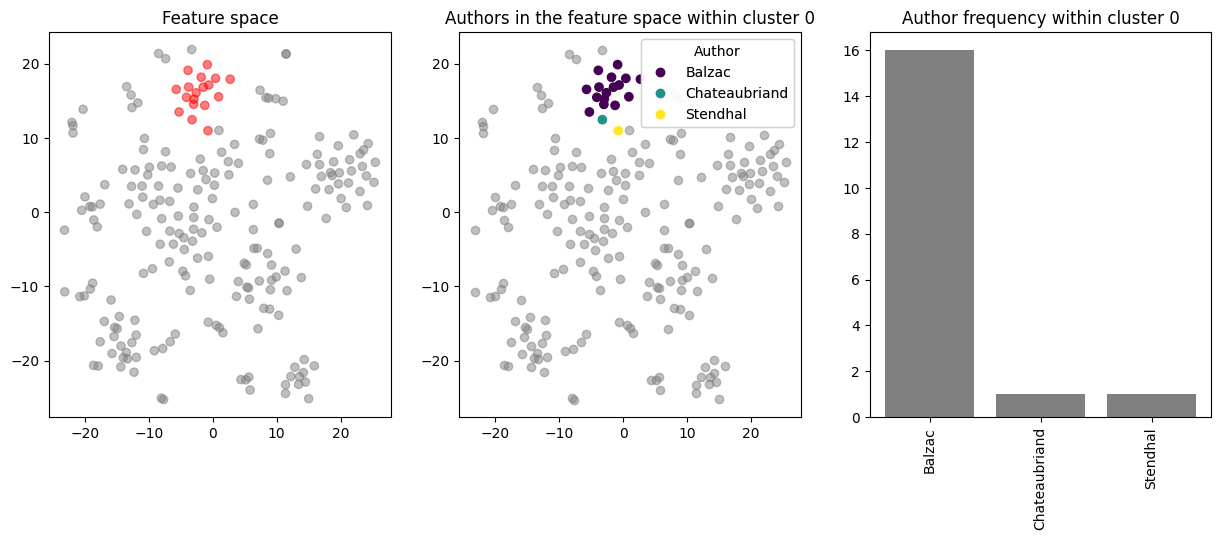

In [395]:
plot_one_cluster(0)

We observe that within cluster 0, 16 out of 18 documents are written by Balzac. The two other documents, François-Rene-de_Vie-de-Rance and Chroniques-italiennes were written by Châteaubriand and Stendhal, respectively, two authors who are contempory from Balzac. The documents are located at the boundary of the cluster, in particular Stendhal's novel with a silhouette score of 0.45 which is in the worst decile of the silhouette scores of cluster with an average 0.62.

On top, texts by Balzac are not included in other clusters, thus we can interpret cluster 0 as the one representing Balzac texts.

**Cluster 1**

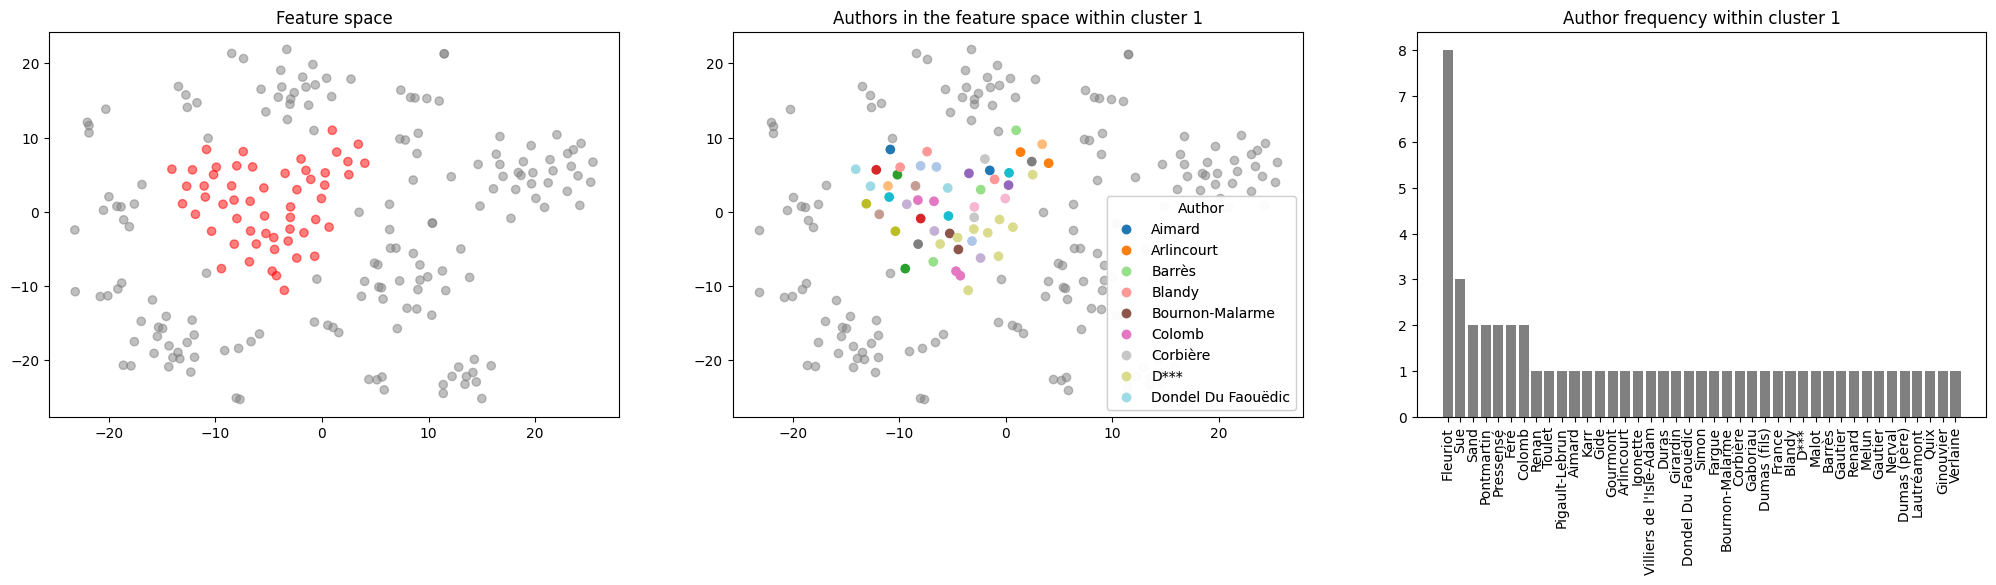

In [396]:
plot_one_cluster(1, figsize=(25,5))

Cluster 1 is very diverse in terms of author and cannot be interpreted with respect to this metdata. Nevertheless, Fleuriot is overrepresented within it. 

**Cluster 2**

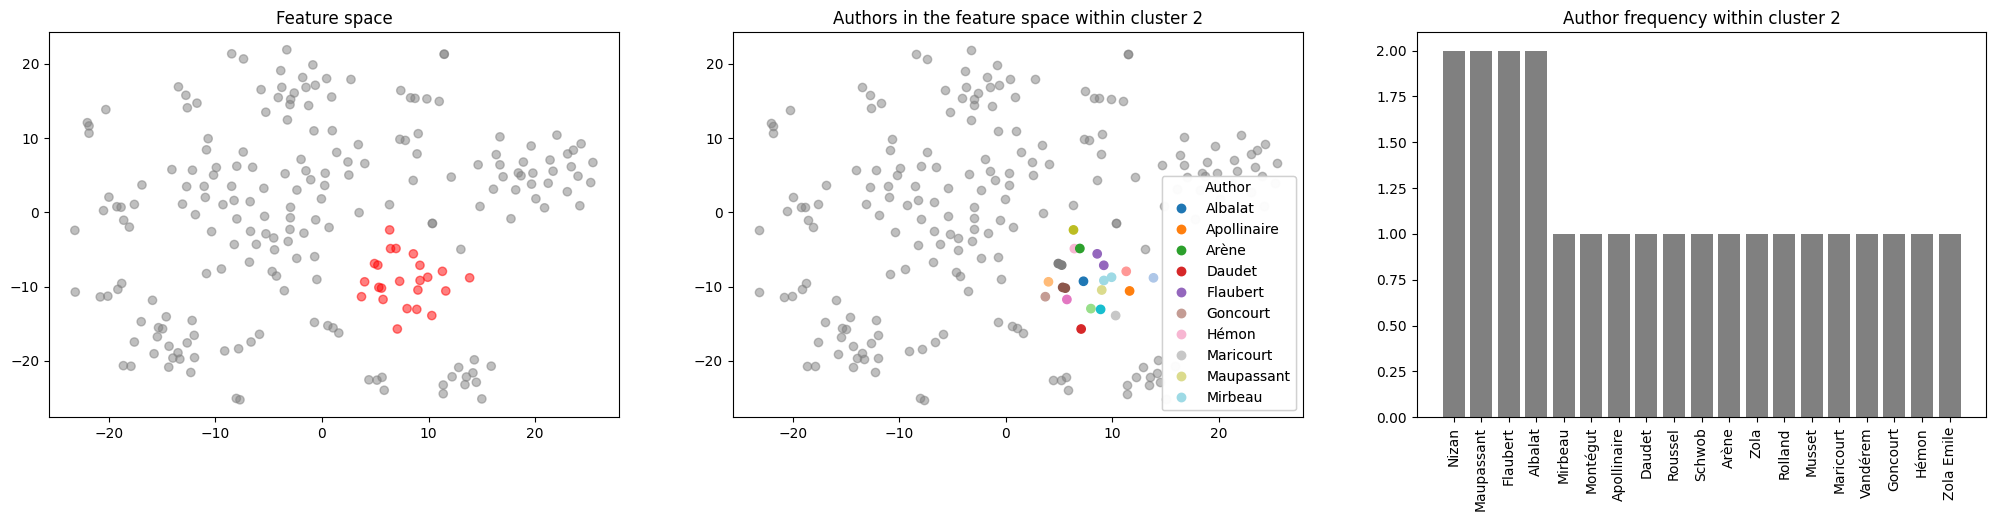

In [397]:
plot_one_cluster(2, figsize=(25,5))

Cluster 2 is very diverse in terms of author and cannot be interpreted with respect to this metadata.

In [398]:
set(data.loc[cluster_labels==1, "author"]).intersection(set(data.loc[cluster_labels==2, "author"]))

set()

However, Cluster 1 and 2 do not share the same authors, thus a clear separation exists between the two clusters with respect to the authors.

**Cluster 3**

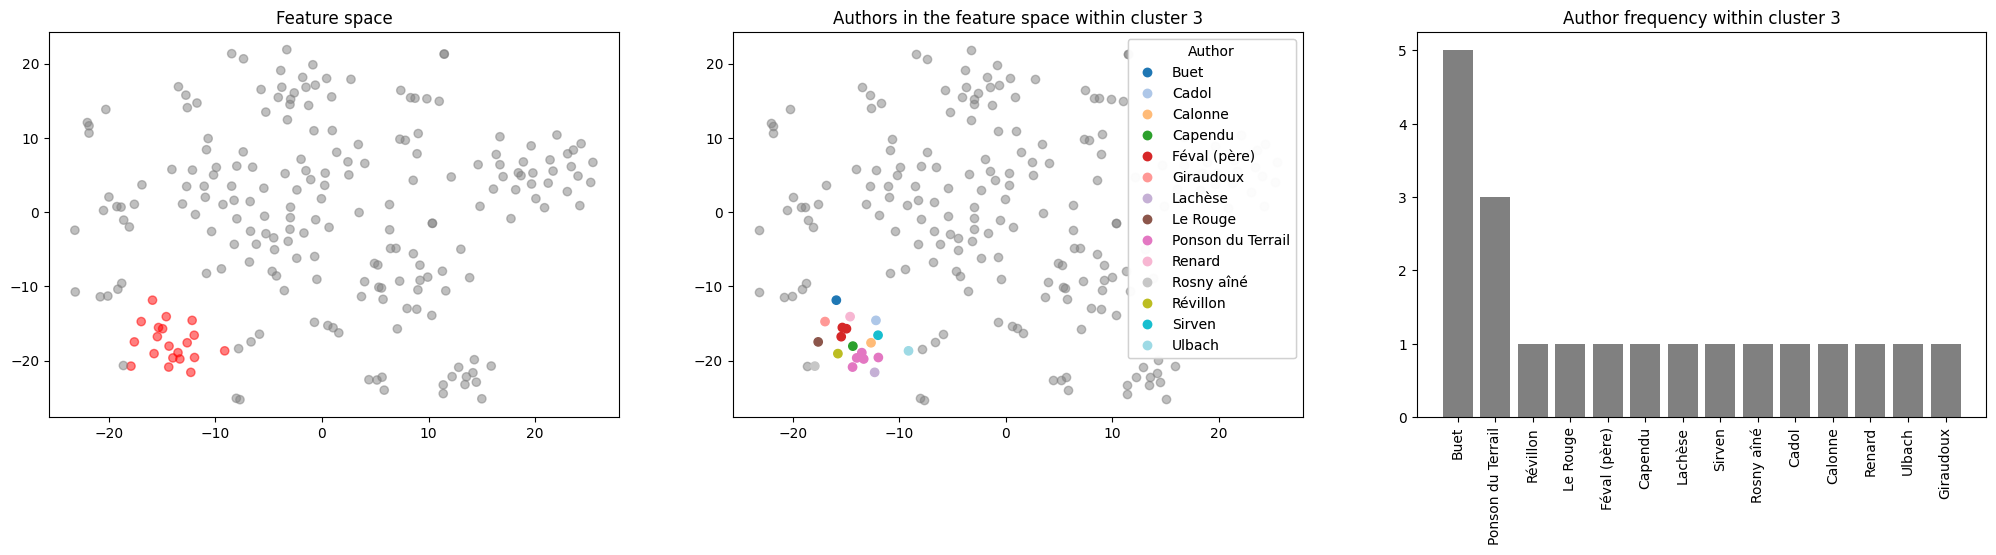

In [399]:
plot_one_cluster(3, figsize=(25,5))

Cluster 3 is also quite diverse in terms of author, however, Buet is overrepresented.

**Cluster 4**

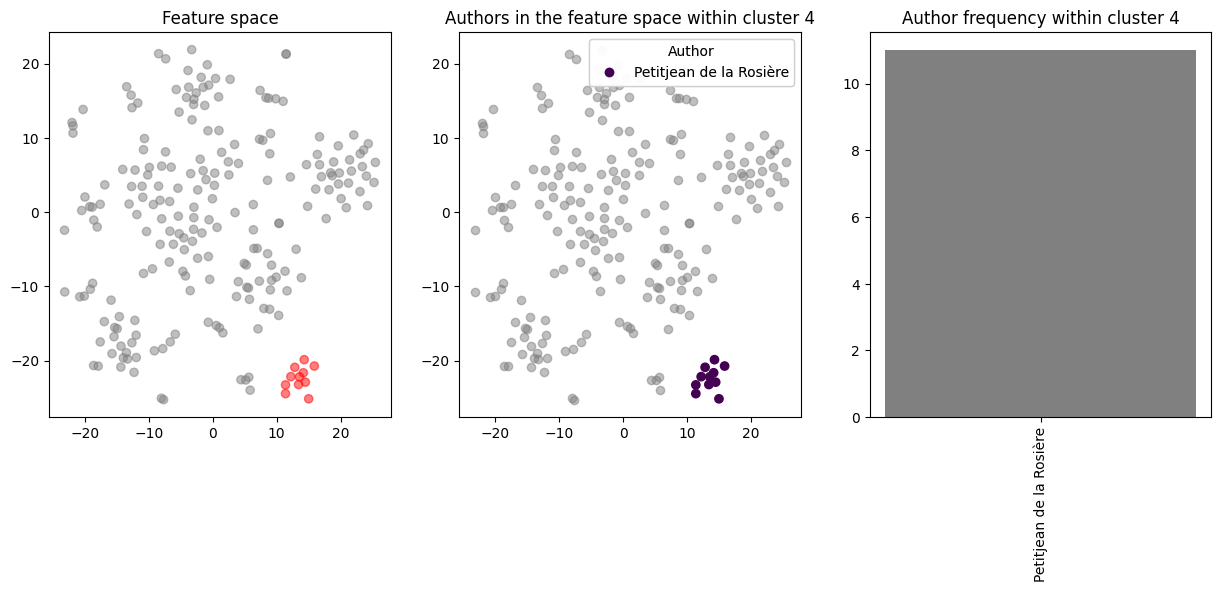

In [400]:
plot_one_cluster(4, figsize=(15,5))

Cluster 4 represents exclusively J-M Petitjean de la Rosière's motifs.

**Cluster 5**

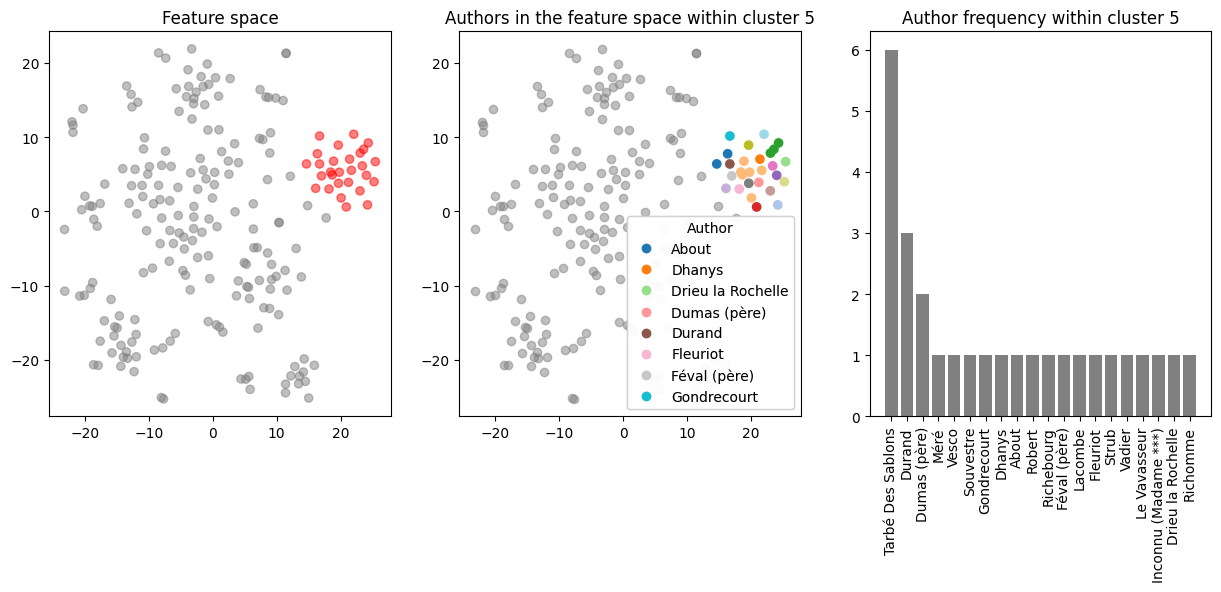

In [401]:
plot_one_cluster(5, figsize=(15,5))

Cluster 5 is diverse with respect to the authors, gender and Etiquette, as shown also by the contingency tables presented above.

**Cluster 6**

This cluster corresponds to Pierre Loti's motifs.

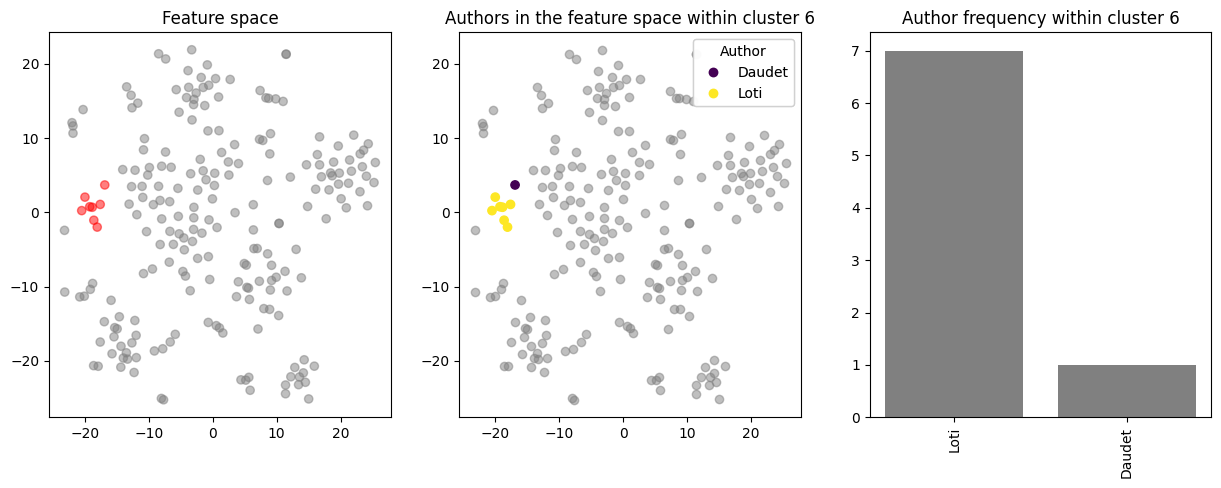

In [480]:
plot_one_cluster(6, figsize=(15,5))

**cluster 7**

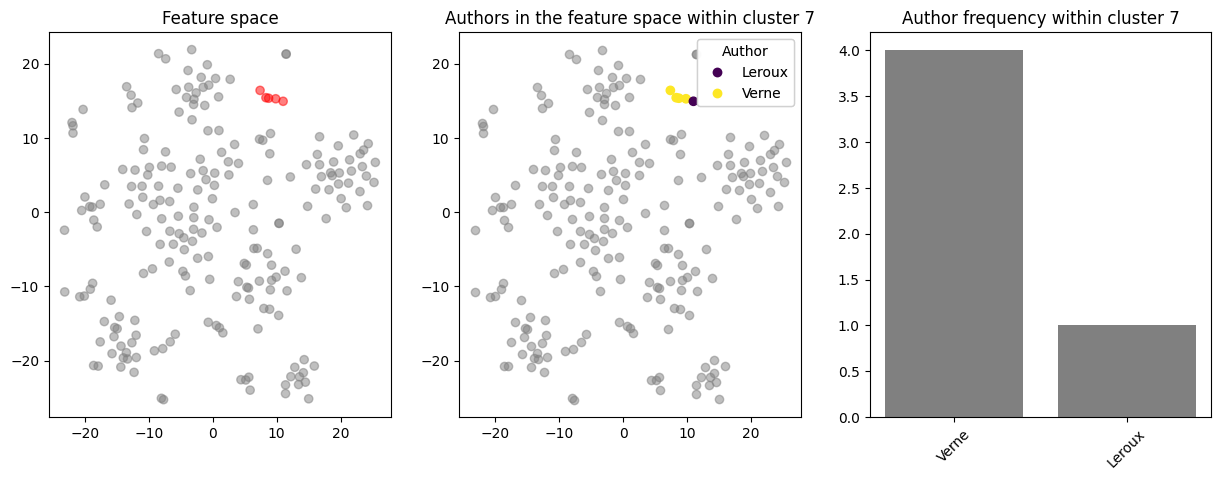

In [278]:
plot_one_cluster(7, figsize=(15,5))

The cluster 7 is the most dense cluster with an average silhouette score of 0.83 and 5 documents. It contains mostly texts from J. Verne and one piece from G. Leroux.

**cluster 8**

In [297]:
np.mean(sample_silhouette_values[cluster_labels == 8])

0.75584716

In [298]:
data.loc[data["cluster"] == 8, "author"]

doc_id
1906_Mistral-Frederic_Mes-origines                                                                    Mistral, Frédéric
1850_Sue-Eugene_Les-Mysteres-du-peuple-Tome-V                                                               Sue, Eugène
1863_Verne-Jules_Cinq-Semaines-en-ballon                                                                   Verne, Jules
1861_Maricourt-Rene-Du-Mesnil_Un-coin-de-la-vieille-Picardie-ou-les-Arquebusiers-de-Senlis    Maricourt, René Du Mesnil
1851_Sue-Eugene_Les-Mysteres-du-peuple-Tome-VI                                                              Sue, Eugène
Name: author, dtype: object